# Imports

In [1]:
import sys
import os
import shutil
import gc
import numpy as np
import scipy.integrate as it
import subprocess as sub
import matplotlib.pyplot as plt
import linecache as l
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit
from scipy import fftpack
import re, csv, math
import itertools

# Matplotlib Settings

import matplotlib
from matplotlib import rc

# Setting font size
fontsize = 30
rc('font', **{'family':'serif', 'serif':['Times'], 'size': fontsize})
rc('pdf', fonttype=42)
rc('text', usetex=True)
params = {'axes.labelsize': fontsize,'axes.titlesize':fontsize, 'legend.fontsize': fontsize, 'xtick.labelsize': fontsize, 'ytick.labelsize': fontsize}
matplotlib.rcParams.update(params)
pot = 1
markers = ['o', '^', 's', 'v','>','<','1','2','3','8']
colors = ['k', 'r', 'steelblue','mediumseagreen','b','g','c','m','y','w']

# Data reading and splitting

In [2]:
def avedata(file_name):
    VAL = np.loadtxt(file_name, dtype = int,skiprows=3,max_rows=1)
    maxrows = VAL[1]
    a = 4
    bindat = np.loadtxt(file_name, dtype = float,skiprows=a,max_rows=int(maxrows))[:,[0,1,2]]
    sum_dat =[]
    for i in range(5):
        VAL1 = np.loadtxt(file_name, dtype = float,skiprows=a,max_rows=int(maxrows))[:,3].reshape(maxrows,1)
        sum_dat.append(VAL1)
        a += maxrows+1
    ave_dat = np.sum(sum_dat,axis=0)/5
    bindat=np.append(bindat, ave_dat, axis=1)
    return bindat

In [3]:
pot = 1
prodrun=5000000
dt=1.0
A=1890
kb=1.987204e-3  #real units
kCal2Joule=4184
avaga=6.02214179e23
fs2s=1.0e-15
A2m =1.0e-10
K_real2SI=A2m*A2m*avaga*fs2s/(kCal2Joule)  #kapitza
K_real2SIcond=kCal2Joule/(avaga*fs2s*A2m)  #conductivity

In [4]:
def SmoothGrad(x_left, T_graL, x_mid, Tw, x_right, T_graR,x_leftfull,x_midfull,x_rightfull):
    
    pL=np.poly1d(np.polyfit(x_left,T_graL,1))
    pmid=np.poly1d(np.polyfit(x_mid,Tw,1))
    pR=np.poly1d(np.polyfit(x_right,T_graR,1))

    #x=np.concatenate([x_left,x_mid,x_right],axis=0)
    #p=np.concatenate([pL(x_left),pmid(x_mid),pR(x_right)],axis=0)
    L=np.column_stack((x_left,pL(x_left)))
    Lfull=np.column_stack((x_leftfull,pL(x_leftfull)))
    M=np.column_stack((x_mid,pmid(x_mid)))
    Mfull=np.column_stack((x_midfull,pmid(x_midfull)))
    R=np.column_stack((x_right,pR(x_right)))
    Rfull=np.column_stack((x_rightfull,pR(x_rightfull)))
    return L,M,R,Lfull,Mfull,Rfull

In [5]:
def cutXT2(x_left, T_graL, x_mid, Tw, x_right, T_graR):
    n=np.size(x_left)
    #print(x_left)
    x_left=np.delete(x_left, [0,1,2], axis=0)
    x_left=x_left[0:6]
    n=np.size(x_right)
    x_right=np.delete(x_right, [0,n-1,n-2,n-3], axis=0)
    x_right=x_right[0:6]
    n=np.size(x_mid)
    x_mid=np.delete(x_mid,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,n-51,n-50,n-49,n-48,n-47,n-46,n-45,n-44,n-43,n-42,n-41,n-40,n-39,n-38,n-37,n-36,n-35,n-34,n-33,n-32,n-31,n-30,n-29,n-28,n-27,n-26,n-25,n-24,n-23,n-22,n-21,n-20,n-19,n-18,n-17,n-16,n-15,n-14,n-13,n-12,n-11,n-10,n-9,n-8,n-7,n-6,n-5,n-4,n-3,n-2,n-1])
    n=np.size(T_graL)
    T_graL=np.delete(T_graL, [0,1,2], axis=0)
    T_graL=T_graL[0:6]
    n=np.size(T_graR)
    T_graR=np.delete(T_graR, [0,n-1,n-2,n-3], axis=0)
    T_graR=T_graR[0:6]    
    n=np.size(Tw)
    Tw=np.delete(Tw,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,n-51,n-50,n-49,n-48,n-47,n-46,n-45,n-44,n-43,n-42,n-41,n-40,n-39,n-38,n-37,n-36,n-35,n-34,n-33,n-32,n-31,n-30,n-29,n-28,n-27,n-26,n-25,n-24,n-23,n-22,n-21,n-20,n-19,n-18,n-17,n-16,n-15,n-14,n-13,n-12,n-11,n-10,n-9,n-8,n-7,n-6,n-5,n-4,n-3,n-2,n-1])
    #print(x_left, T_graL, x_mid, Tw, x_right, T_graR)
    return x_left, T_graL, x_mid, Tw, x_right, T_graR

In [6]:
def calcThermal(x_left, T_graL, x_mid, Tw, x_right, T_graR,Q_flux):
    slope_TgraL, c_TgraL=np.polyfit(x_left,T_graL,1)
    slope_Tw, c_Tw=np.polyfit(x_mid,Tw,1)
    slope_TgraR, c_TgraR=np.polyfit(x_right,T_graR,1)
    
    k_graL=-(Q_flux/(slope_TgraL))    #W/mK
    k_W=-(Q_flux/(slope_Tw))
    k_graR=-(Q_flux/(slope_TgraR))

    x_intL=-wall
    x_intLw=-wall
    x_intR=wall
    x_intRw=wall

    Tint_lGra=slope_TgraL*x_intL+c_TgraL
    Tint_lWat=slope_Tw*x_intLw+c_Tw
    Tint_rWat=slope_Tw*x_intRw+c_Tw
    Tint_rGra=slope_TgraR*x_intR+c_TgraR
    delTL= Tint_lGra-Tint_lWat
    delTR=Tint_rWat-Tint_rGra
    G_L=((Tint_lGra-Tint_lWat))/Q_flux    #m2K/W
    G_R=((Tint_rWat-Tint_rGra))/Q_flux
    print("Temperature drop left  =",delTL,'K')
    print("Temperature drop right  =",delTR,'K')
    return k_graL,k_W,k_graR,G_L,G_R 

100 350 0
17561.0078807862 15491.126136005
-1.7487901596185819e-06
-1.7487901596185819e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0
[303.8162 303.5956 305.3458 305.452  304.5548 304.9818] [390.6092 391.4438 392.6836 393.4838 393.5824 393.9954]
Temperature drop left  = -7.180118714346349 K
Temperature drop right  = -10.49409351249136 K
########## 350 1 #########################
Kapitza left       = 5.909533851766997e-09 m2K/W
Kapitza length left       = 0.9382335537896683 nm
Kapitza right      = 8.637071798237218e-09 m2K/W
Kapitza length right      = 1.3712740752256778 nm
heatflux    = -1.7487901596185819e-06 W/m^2
###################################
3.286364 -39.95 2.9852800000000004 -39.75


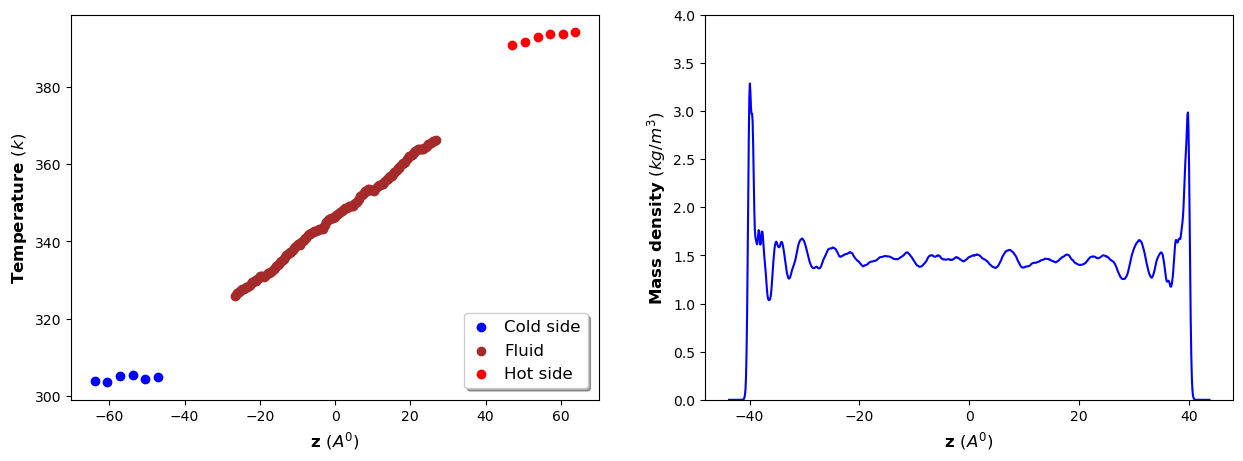

100 350 0.1
19230.0920449687 16895.5312429855
-1.9114086395742965e-06
-1.9114086395742965e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0.1
[302.7794 304.1972 302.597  302.7578 302.7296 303.4306] [390.3726 392.698  391.9964 393.8522 391.089  393.1622]
Temperature drop left  = -8.978412534087681 K
Temperature drop right  = -6.370599066221587 K
########## 350 1 #########################
Kapitza left       = 6.7609124532353055e-09 m2K/W
Kapitza length left       = 1.0808884585977319 nm
Kapitza right      = 4.797180169418814e-09 m2K/W
Kapitza length right      = 0.7669403671182611 nm
heatflux    = -1.9114086395742965e-06 W/m^2
###################################
3.41985 -38.95 3.166602 -39.75


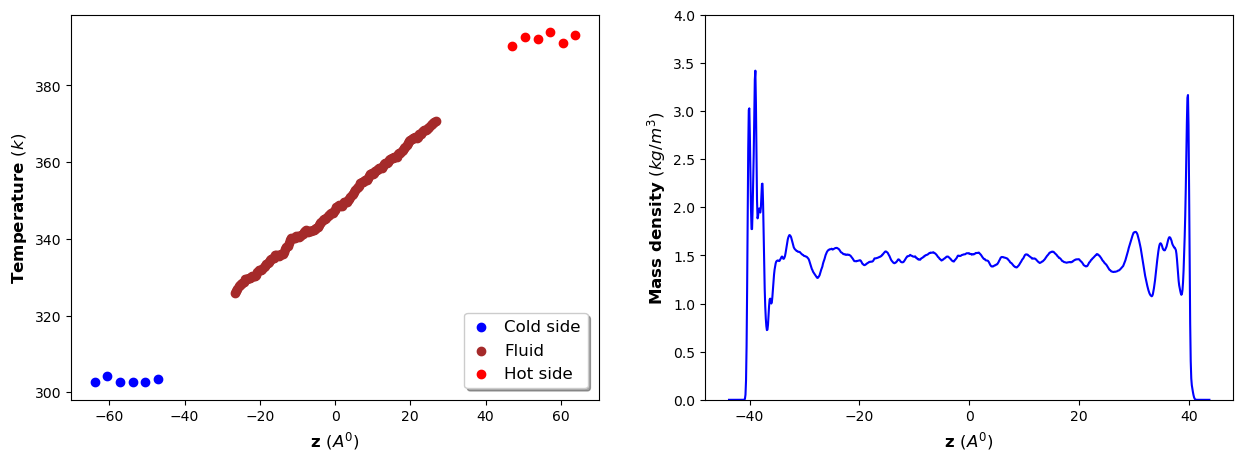

100 350 0.2
20502.6681683835 18038.7893646812
-2.0392305573050107e-06
-2.0392305573050107e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0.2
[302.914  303.6466 303.7576 303.7138 302.7682 304.8754] [389.6308 389.7942 387.4    390.172  391.7556 391.7092]
Temperature drop left  = -4.467908405621245 K
Temperature drop right  = -2.209813583290952 K
########## 350 1 #########################
Kapitza left       = 3.1535319237641286e-09 m2K/W
Kapitza length left       = 0.5071837799775207 nm
Kapitza right      = 1.5597270686453668e-09 m2K/W
Kapitza length right      = 0.25085151808597445 nm
heatflux    = -2.0392305573050107e-06 W/m^2
###################################
4.285392 -39.05 2.826302 -39.75


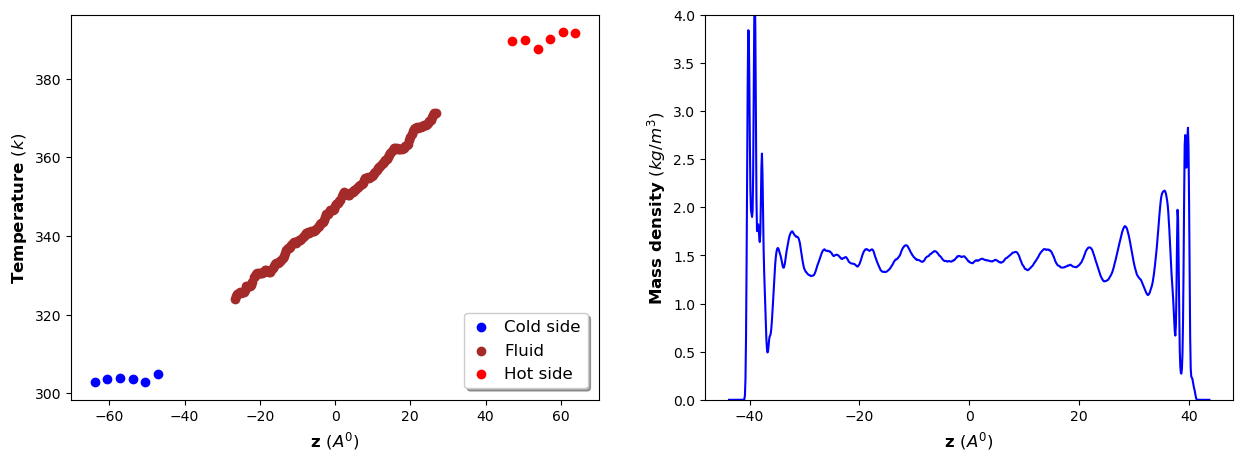

100 350 0.3
18366.1102409757 15739.6379096717
-1.804536939187693e-06
-1.804536939187693e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0.3
[302.2266 302.5556 302.9818 303.2296 303.7864 305.5818] [392.2642 390.7438 389.9872 389.5994 390.7682 389.746 ]
Temperature drop left  = -6.703750610198142 K
Temperature drop right  = -9.3552263005393 K
########## 350 1 #########################
Kapitza left       = 5.347014646734585e-09 m2K/W
Kapitza length left       = 0.835531108358246 nm
Kapitza right      = 7.461872459336868e-09 m2K/W
Kapitza length right      = 1.166001400460925 nm
heatflux    = -1.804536939187693e-06 W/m^2
###################################
4.377614 -40.15 3.52837 -39.25


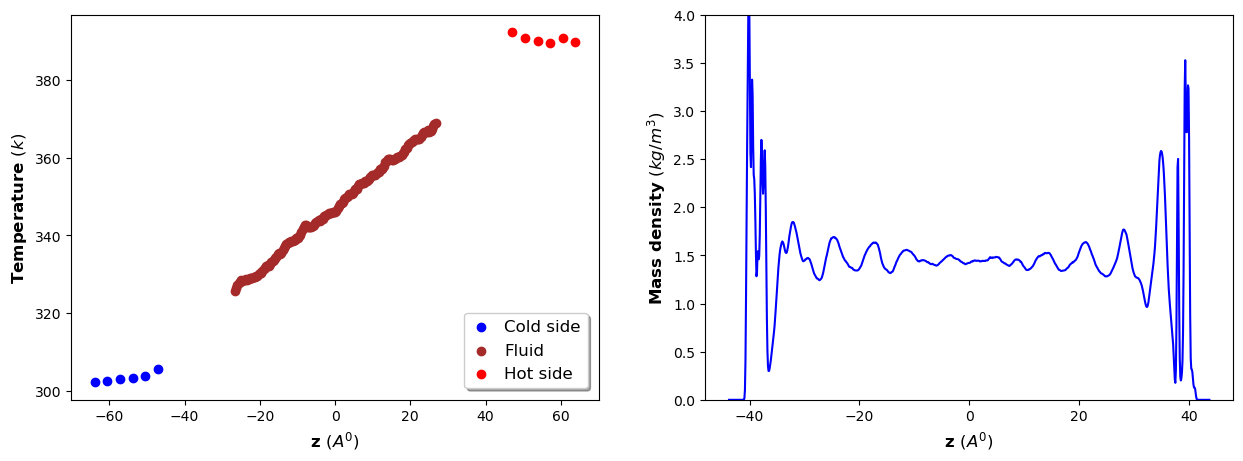

100 350 0.4
17025.238436116 14188.7948323249
-1.6515361517693598e-06
-1.6515361517693598e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0.4
[303.5348 302.9744 305.086  304.5336 304.2958 305.462 ] [391.7336 391.5514 390.8224 393.7434 392.8274 394.4324]
Temperature drop left  = -12.690076492141884 K
Temperature drop right  = -10.739949142674277 K
########## 350 1 #########################
Kapitza left       = 1.1059499057989327e-08 m2K/W
Kapitza length left       = 1.8091831912099696 nm
Kapitza right      = 9.3599481058929e-09 m2K/W
Kapitza length right      = 1.5311598377998947 nm
heatflux    = -1.6515361517693598e-06 W/m^2
###################################
5.021744 -40.15 3.806666 -39.95


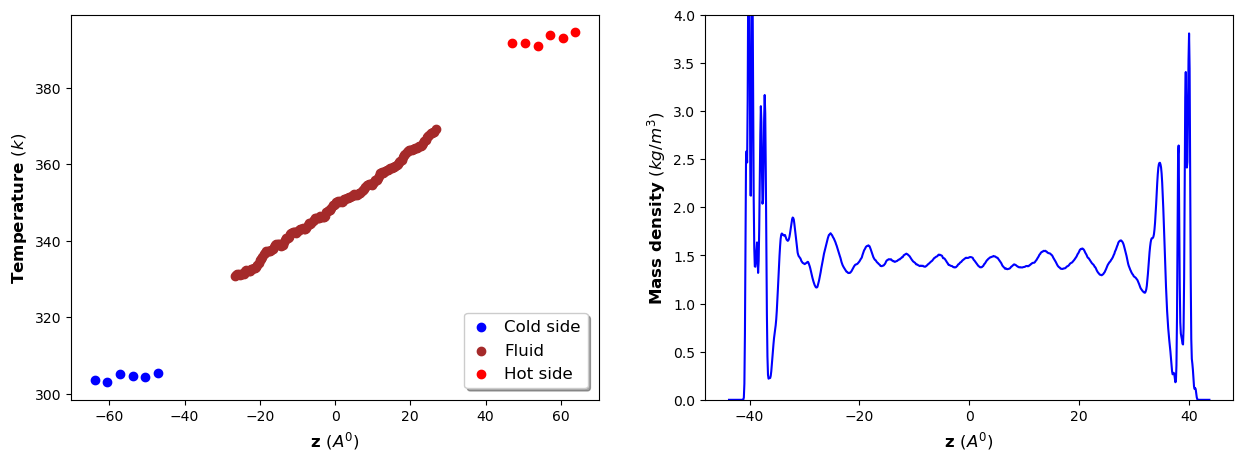

100 350 0.5
15406.6322374033 13350.3682814219
-1.5215344189854602e-06
-1.5215344189854602e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=100/c=0.5
[304.313  305.6448 304.0616 304.1734 303.3504 304.0046] [392.3708 391.8066 393.5258 392.1676 392.6258 393.0426]
Temperature drop left  = -17.059143113836228 K
Temperature drop right  = -9.569324370927802 K
########## 350 1 #########################
Kapitza left       = 1.6137443411448047e-08 m2K/W
Kapitza length left       = 2.4068394740163166 nm
Kapitza right      = 9.052297028705296e-09 m2K/W
Kapitza length right      = 1.3501163265893978 nm
heatflux    = -1.5215344189854602e-06 W/m^2
###################################
5.318686 -39.45 4.929078 -40.05


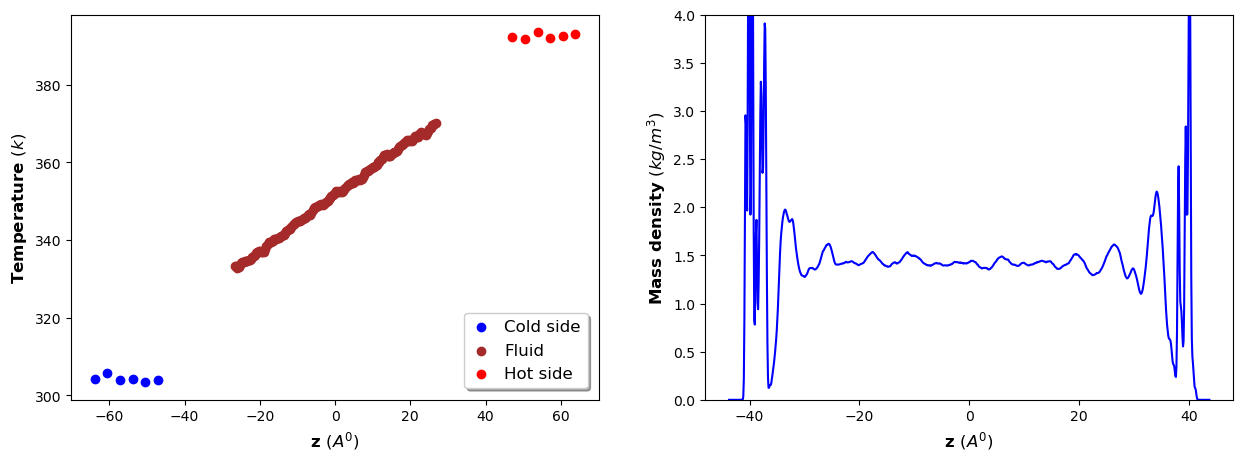

300 350 0
24000.4115562983 21430.7553485478
-2.4037654447008518e-06
-2.4037654447008518e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0
[303.4364 304.3366 304.8116 305.0096 305.441  306.2842] [388.8182 389.6394 390.2066 388.9552 391.3604 391.3292]
Temperature drop left  = -14.200163153974756 K
Temperature drop right  = -14.76431669673002 K
########## 350 1 #########################
Kapitza left       = 8.50277226766682e-09 m2K/W
Kapitza length left       = 1.8747449083761483 nm
Kapitza right      = 8.840576069357842e-09 m2K/W
Kapitza length right      = 1.9492260231601533 nm
heatflux    = -2.4037654447008518e-06 W/m^2
###################################
3.170208 -30.99 3.01568 -30.69


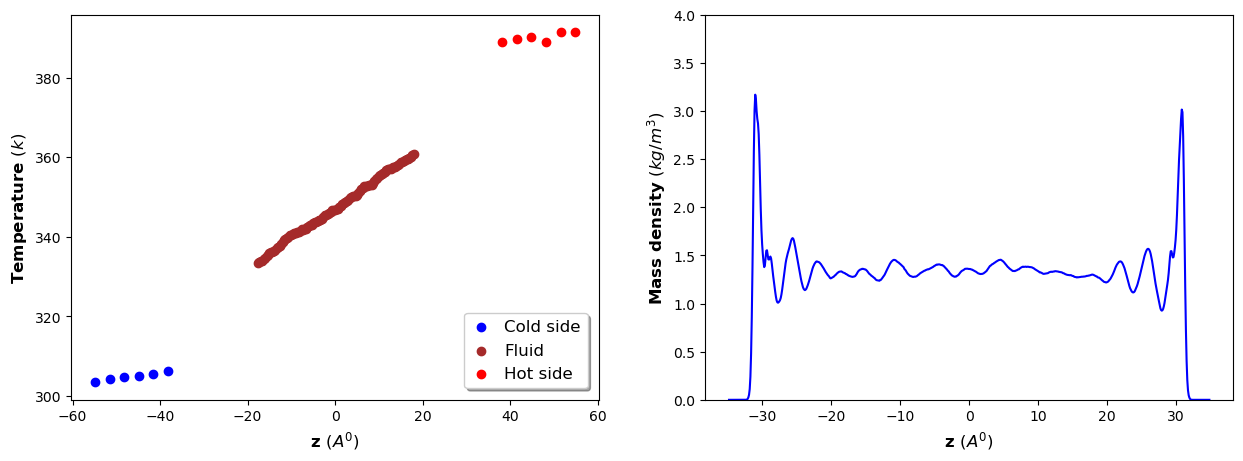

300 350 0.1
25781.5681482732 23909.5529379784
-2.6291598458334183e-06
-2.6291598458334183e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0.1
[303.6218 306.3318 304.7376 306.0498 306.0478 305.5414] [386.3174 388.2676 388.5436 388.039  388.1694 388.924 ]
Temperature drop left  = -10.903008934205673 K
Temperature drop right  = -6.305964226506319 K
########## 350 1 #########################
Kapitza left       = 5.968822690003581e-09 m2K/W
Kapitza length left       = 1.20176873494224 nm
Kapitza right      = 3.4521830243977473e-09 m2K/W
Kapitza length right      = 0.6950659856202006 nm
heatflux    = -2.6291598458334183e-06 W/m^2
###################################
2.9680380000000004 -31.29 3.278492 -30.79


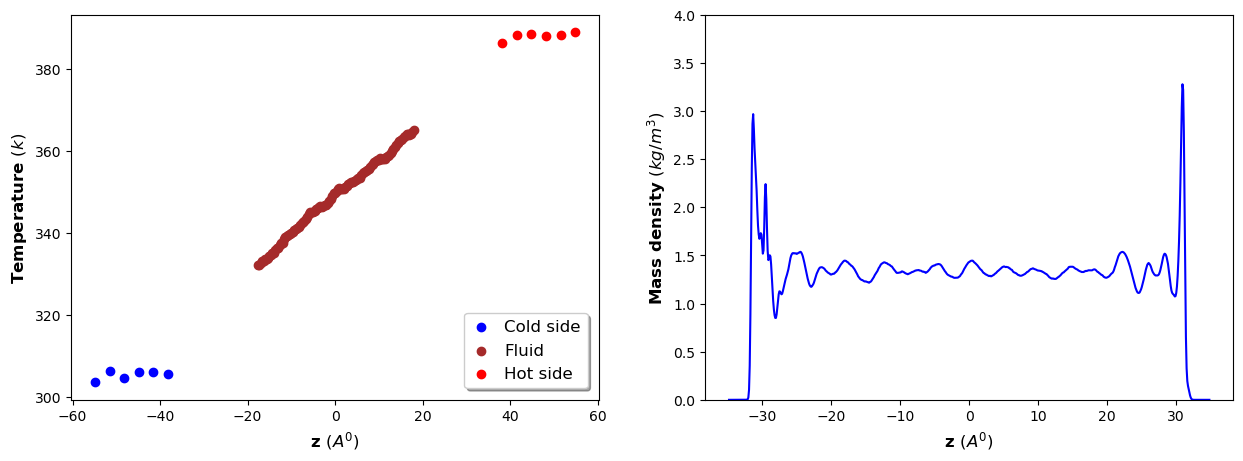

300 350 0.2
27376.5598613599 25147.7405778945
-2.7790635153044652e-06
-2.7790635153044652e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0.2
[306.4118 305.9474 305.2774 306.3286 306.3706 307.9506] [386.4082 390.061  388.9346 391.0202 390.1582 390.2322]
Temperature drop left  = -8.51014485242689 K
Temperature drop right  = -6.102471479585006 K
########## 350 1 #########################
Kapitza left       = 4.4075554069797014e-09 m2K/W
Kapitza length left       = 0.9077601280575941 nm
Kapitza right      = 3.1605785368170243e-09 m2K/W
Kapitza length right      = 0.6509384255893299 nm
heatflux    = -2.7790635153044652e-06 W/m^2
###################################
4.056068 -31.49 2.840216 -30.89


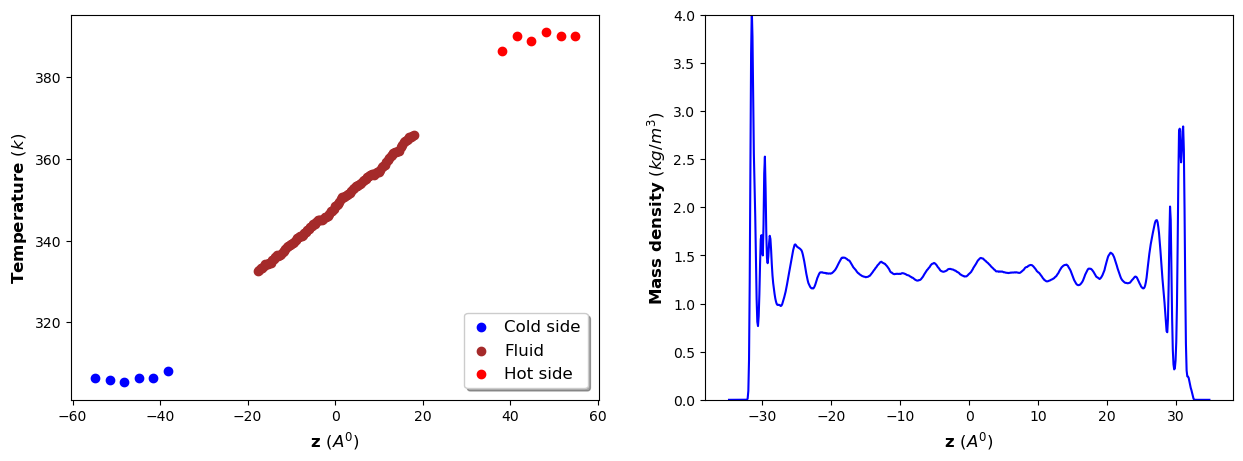

300 350 0.3
24179.1306823378 21884.9408084341
-2.437252459829201e-06
-2.437252459829201e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0.3
[307.7322 306.8548 305.7802 306.3796 306.3298 308.0496] [386.5052 388.745  386.5446 388.2002 389.1888 388.8138]
Temperature drop left  = -11.784409968118382 K
Temperature drop right  = -11.583873308771558 K
########## 350 1 #########################
Kapitza left       = 6.959317111381517e-09 m2K/W
Kapitza length left       = 1.4594679607270196 nm
Kapitza right      = 6.8408896119456265e-09 m2K/W
Kapitza length right      = 1.4346320266361545 nm
heatflux    = -2.437252459829201e-06 W/m^2
###################################
4.900106 -31.39 3.53845 -30.29


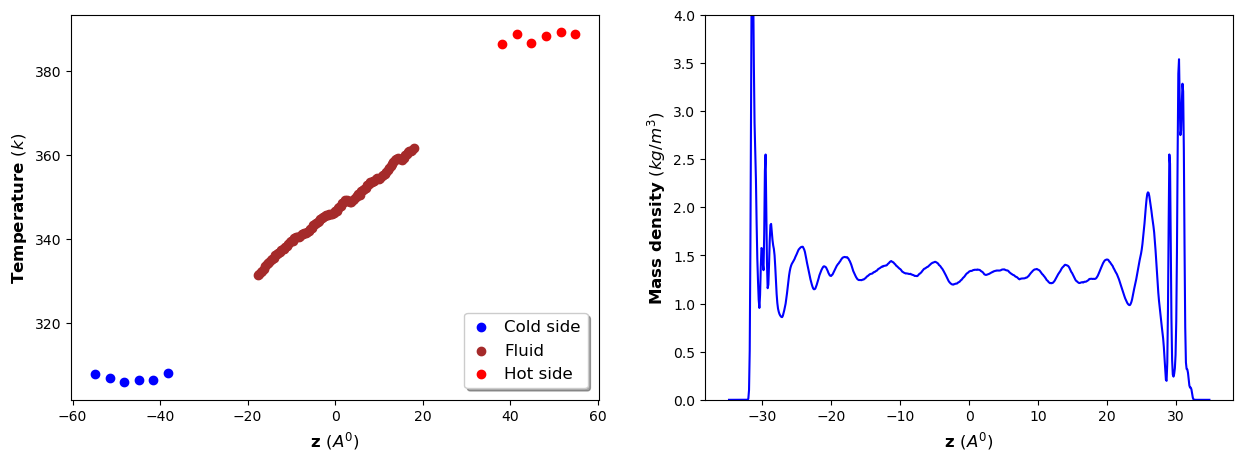

300 350 0.4
21698.2432384849 19260.7528352183
-2.167142649402286e-06
-2.167142649402286e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0.4
[305.0354 304.7896 306.1852 305.957  307.6872 308.225 ] [389.3976 388.786  389.5912 392.9748 391.676  392.6218]
Temperature drop left  = -14.100747704671164 K
Temperature drop right  = -16.805388734746998 K
########## 350 1 #########################
Kapitza left       = 9.365132878022318e-09 m2K/W
Kapitza length left       = 2.0315885770136353 nm
Kapitza right      = 1.1161443482574195e-08 m2K/W
Kapitza length right      = 2.4212642124272254 nm
heatflux    = -2.167142649402286e-06 W/m^2
###################################
5.459646000000001 -31.49 3.952156 -30.99


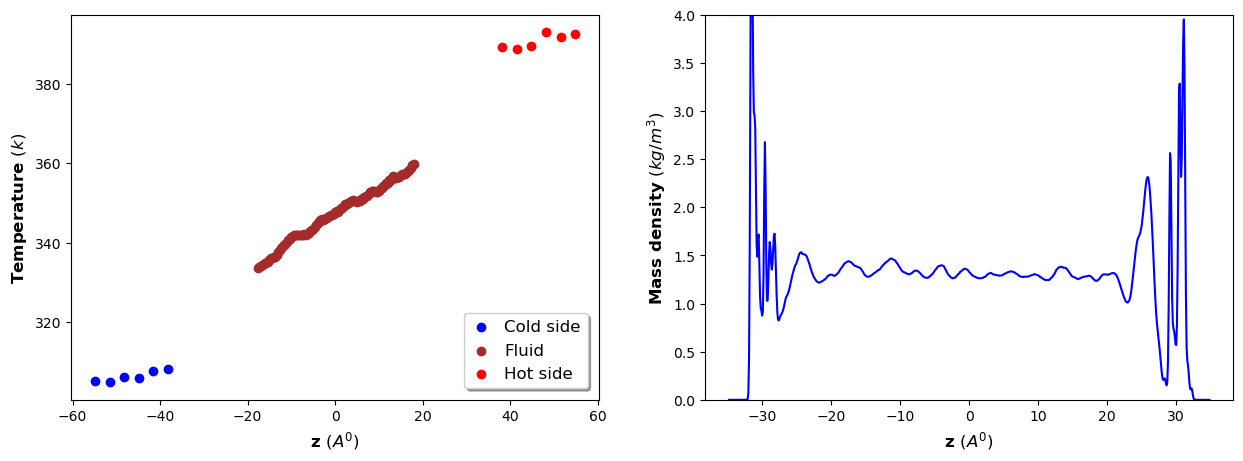

300 350 0.5
20413.9483057275 17958.1746894502
-2.03027105794591e-06
-2.03027105794591e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=300/c=0.5
[305.0408 303.7428 304.2642 305.1038 304.2652 304.9888] [389.529  391.3834 391.3588 391.5648 393.826  391.7994]
Temperature drop left  = -17.237577102756973 K
Temperature drop right  = -14.96270569427088 K
########## 350 1 #########################
Kapitza left       = 1.2220289623104459e-08 m2K/W
Kapitza length left       = 2.278905448402082 nm
Kapitza right      = 1.0607557897450664e-08 m2K/W
Kapitza length right      = 1.9781545472569375 nm
heatflux    = -2.03027105794591e-06 W/m^2
###################################
7.11199 -31.59 4.887264 -31.09


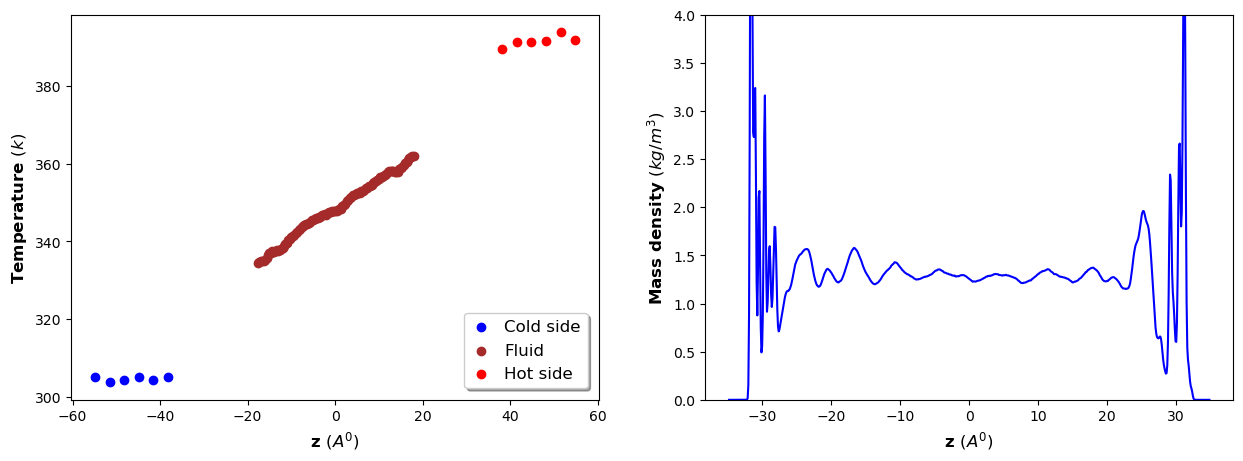

400 350 0
29579.1761833037 27248.5970866049
-3.0067604904713546e-06
-3.0067604904713546e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0
[306.4078 307.6506 307.5506 308.3962 308.036  309.9128] [387.4168 387.5024 388.5232 388.8466 390.909  390.7262]
Temperature drop left  = -12.85708793618818 K
Temperature drop right  = -15.607459019698808 K
########## 350 1 #########################
Kapitza left       = 6.154646024908508e-09 m2K/W
Kapitza length left       = 1.6206733965478544 nm
Kapitza right      = 7.471239684387719e-09 m2K/W
Kapitza length right      = 1.967365685486317 nm
heatflux    = -3.0067604904713546e-06 W/m^2
###################################
3.431678 -26.32 3.223874 -26.02


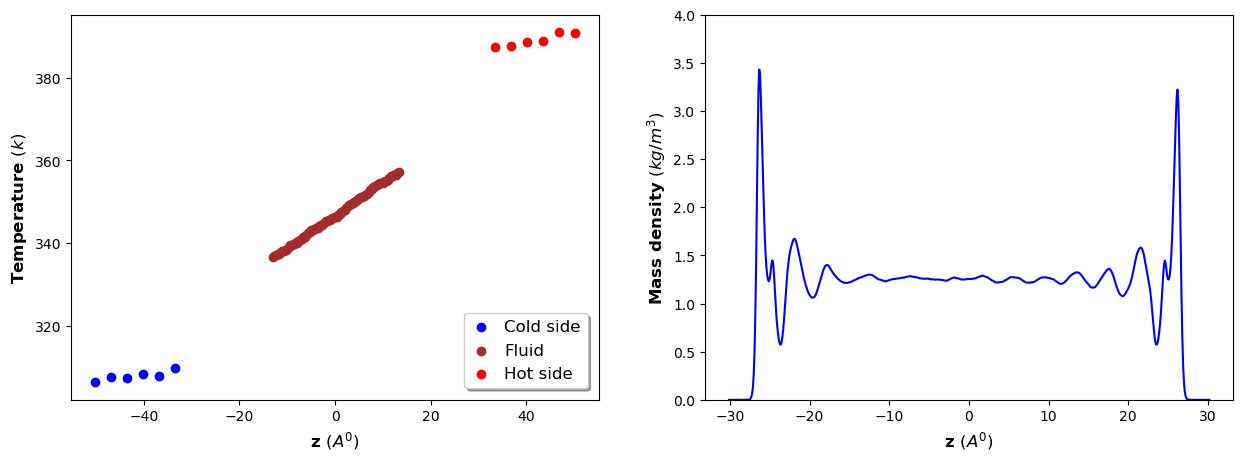

400 350 0.1
31674.514489573 29213.6531406035
-3.2215961709088093e-06
-3.2215961709088093e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0.1
[306.168  305.92   306.067  308.1574 306.6498 309.0032] [383.7358 384.5044 384.9462 386.1358 388.2914 388.054 ]
Temperature drop left  = -13.934761847245056 K
Temperature drop right  = -8.830384532772655 K
########## 350 1 #########################
Kapitza left       = 6.225693718698215e-09 m2K/W
Kapitza length left       = 1.6510861068564266 nm
Kapitza right      = 3.94518902597832e-09 m2K/W
Kapitza length right      = 1.0462844919838556 nm
heatflux    = -3.2215961709088093e-06 W/m^2
###################################
2.980202 -26.72 3.40334 -26.02


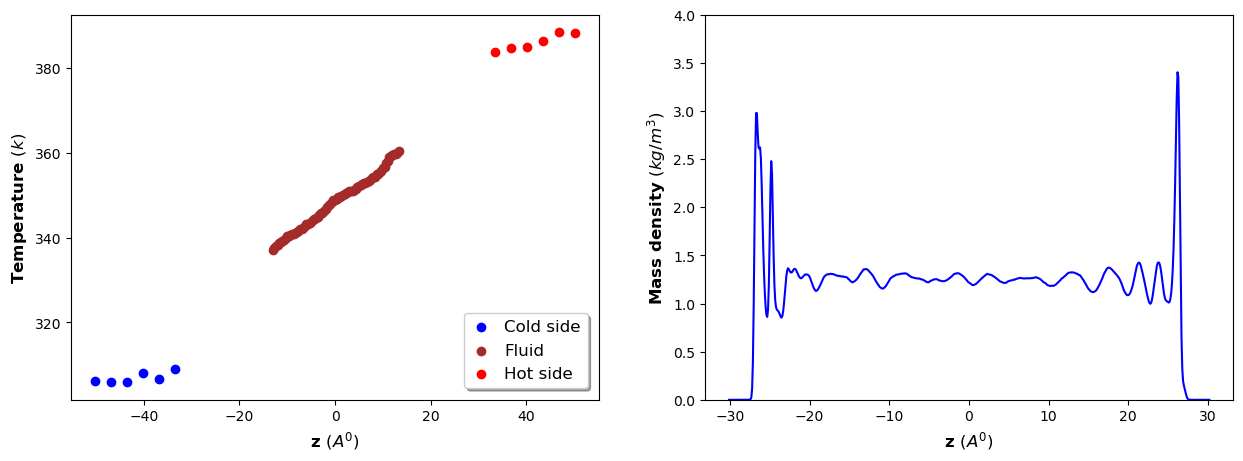

400 350 0.2
32953.4463744613 30198.195340737
-3.3413567045078466e-06
-3.3413567045078466e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0.2
[306.9658 308.314  308.582  310.4998 310.2894 311.6974] [383.5726 385.0992 385.1028 386.504  388.7136 388.0054]
Temperature drop left  = -7.989847828214408 K
Temperature drop right  = -4.9496576621925215 K
########## 350 1 #########################
Kapitza left       = 3.441715500907328e-09 m2K/W
Kapitza length left       = 0.8421925669622548 nm
Kapitza right      = 2.1321198934473104e-09 m2K/W
Kapitza length right      = 0.5217327015147813 nm
heatflux    = -3.3413567045078466e-06 W/m^2
###################################
4.446064 -26.82 2.962728 -26.12


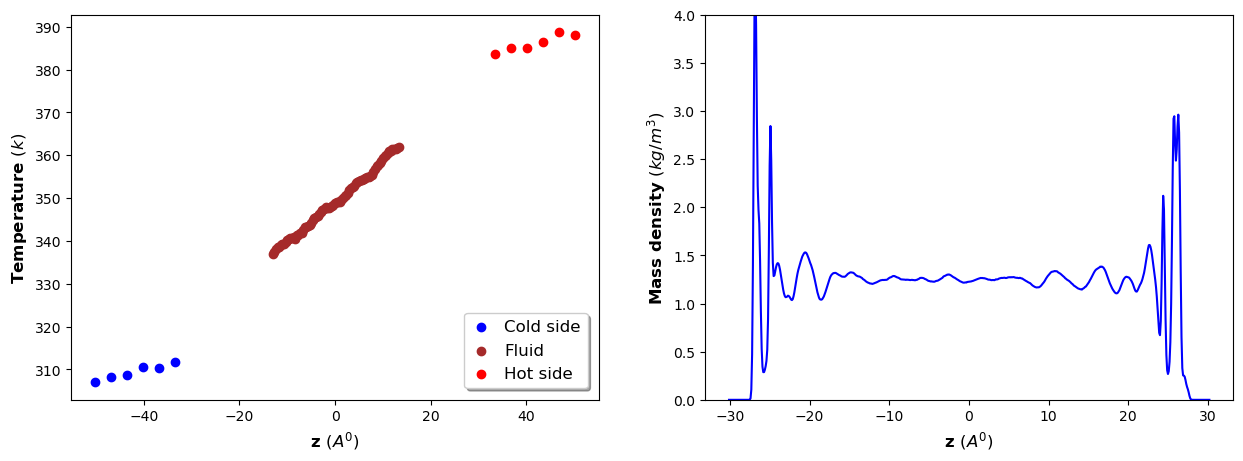

400 350 0.3
29071.0351748631 26976.2246500427
-2.9654634827992485e-06
-2.9654634827992485e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0.3
[306.069  308.3672 307.996  308.3726 311.6958 310.0582] [382.11   385.6172 385.8804 386.302  388.4548 389.1842]
Temperature drop left  = -11.527655063677969 K
Temperature drop right  = -10.14427249769227 K
########## 350 1 #########################
Kapitza left       = 5.595097941441713e-09 m2K/W
Kapitza length left       = 1.438186323351442 nm
Kapitza right      = 4.923655145450956e-09 m2K/W
Kapitza length right      = 1.2655959851279914 nm
heatflux    = -2.9654634827992485e-06 W/m^2
###################################
6.183354 -26.72 3.6034 -25.42


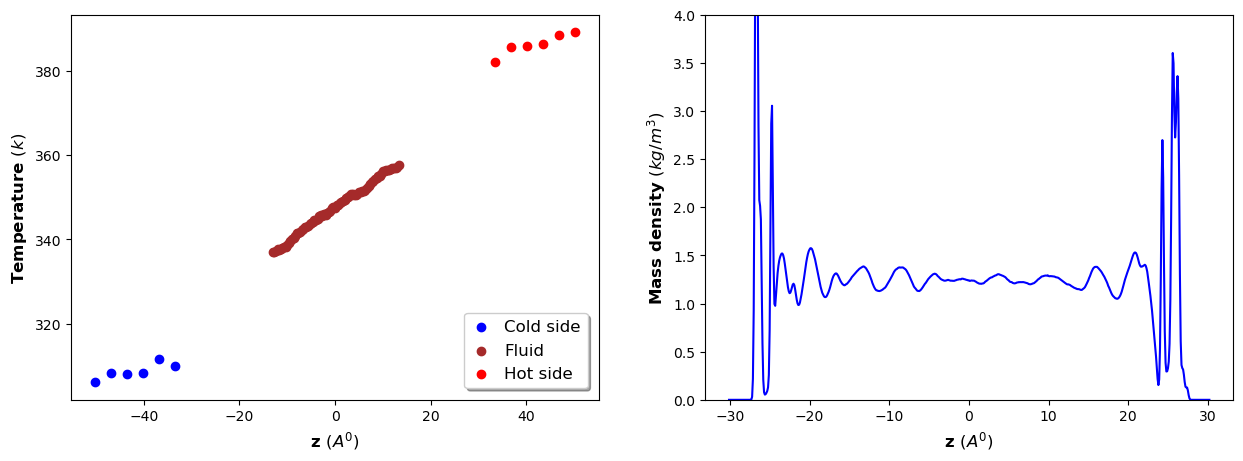

400 350 0.4
24664.8262113675 22377.5322085208
-2.489013673009963e-06
-2.489013673009963e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0.4
[306.744  306.754  306.4374 307.147  307.2228 309.7406] [387.2338 386.897  387.5638 386.1686 388.5096 389.5474]
Temperature drop left  = -18.87303790744079 K
Temperature drop right  = -18.96550194857747 K
########## 350 1 #########################
Kapitza left       = 1.0913745713881723e-08 m2K/W
Kapitza length left       = 2.9004457214288193 nm
Kapitza right      = 1.0967215061932242e-08 m2K/W
Kapitza length right      = 2.9146557777968596 nm
heatflux    = -2.489013673009963e-06 W/m^2
###################################
7.344658 -26.82 3.828166 -26.12


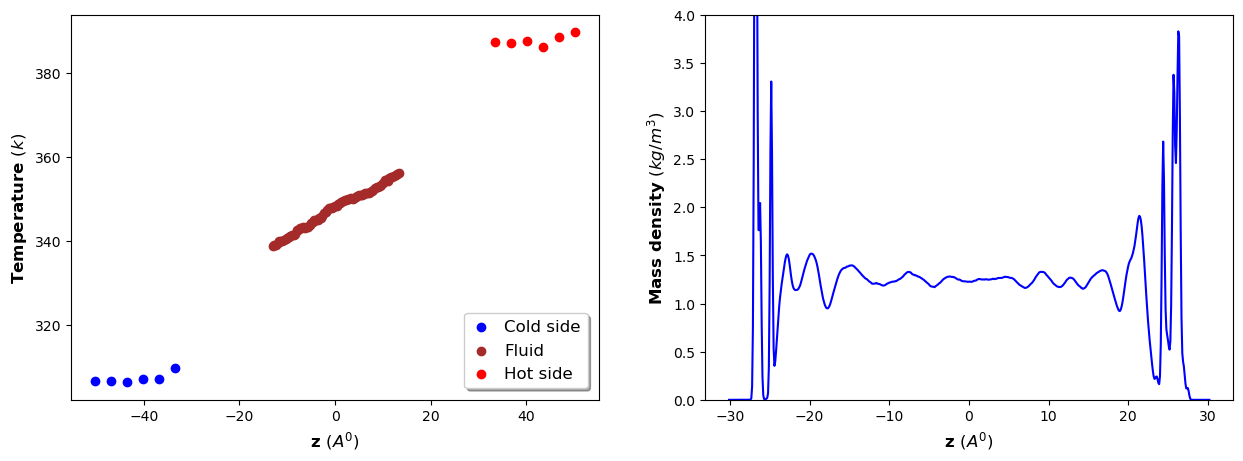

400 350 0.5
22772.6336464406 20395.8814045359
-2.2840484153955822e-06
-2.2840484153955822e-06
/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/bf=400/c=0.5
[305.983  305.767  305.7986 307.139  308.8742 308.8432] [388.7352 389.9154 391.938  390.6622 389.8654 389.992 ]
Temperature drop left  = -23.61329557739805 K
Temperature drop right  = -17.484887752092277 K
########## 350 1 #########################
Kapitza left       = 1.488026270970859e-08 m2K/W
Kapitza length left       = 3.6499475538909554 nm
Kapitza right      = 1.1018357109370854e-08 m2K/W
Kapitza length right      = 2.702669056575598 nm
heatflux    = -2.2840484153955822e-06 W/m^2
###################################
9.19719 -26.82 5.200345999999999 -26.22


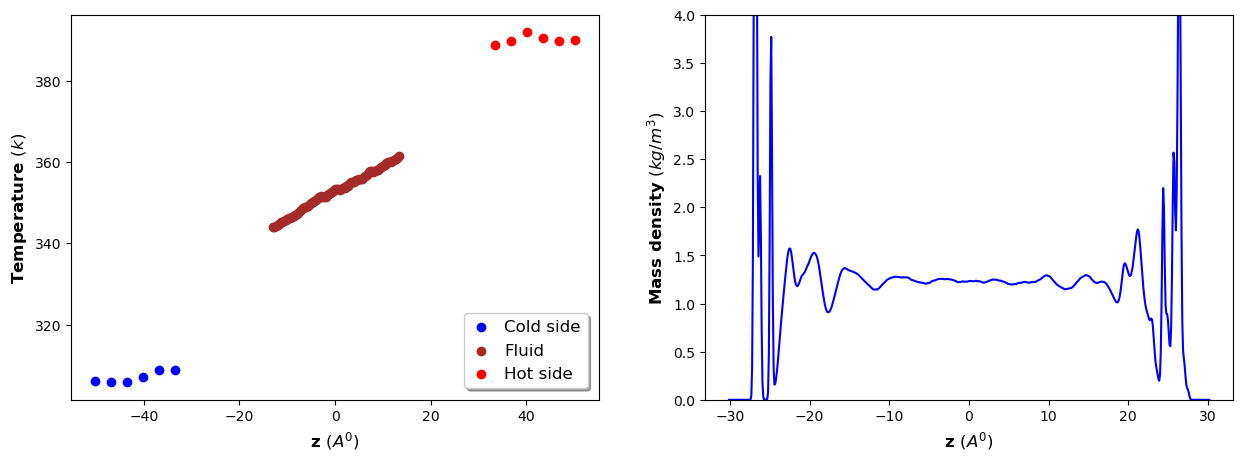

In [7]:
diranl="/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD"
conrange= [100,300,400]
trange= [350]
crange=[0,0.1,0.2,0.3,0.4,0.5]
iruns = [2]
kap=[]
denpeakL=[]
denpeakR=[]
denpeakLz=[]
denpeakRz=[]
Qnet=[]
cf=[]
bulkden=[]
kleft=[]
kright=[]
lk=[]
lkleft=[]
lkright=[]
KvsC=[]
KvsM=[]
    #print(Tfluid,Q)
for con in conrange:
    for c in crange:
        Q=[]
        Tfluid=[]
        Tleft=[]
        Tright=[]
        den =[]
        for irun in iruns:
            T=350
            print(con,T,c)
            heat=np.loadtxt(diranl+'/bf_'+str(con)+'/'+str(c)+'/heatflux.'+str(irun)+"."+str(T)+".dat")
            #heat=np.loadtxt(diranl+str(c)+'/bf_'+str(con)+'/heatfluxfull.'+str(irun)+"."+str(T)+".dat")
           # print(heat[4999][0],heat[3999][0])
            #print(heat[4999][1],heat[3999][1])
            #Heat1=np.absolute(heat[4999][0]-heat[3999][0])
            #Heat2=np.absolute(heat[4999][1]-heat[3999][1])
            Heat1=np.absolute(heat[0])
            Heat2=np.absolute(heat[1])          
            print(Heat1,Heat2)
            Q_fluxreal=-((Heat1+Heat2)*0.5)/(prodrun*dt*A)
            Q_flux=Q_fluxreal
            print(Q_flux)
            Q.append(Q_flux)
            
            datafluid=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_fluid.'+str(irun)+"."+str(T)+".profile")
#datafluid=np.loadtxt(diranl+'tmp_water.profile',skiprows=4)
            tempfluid=datafluid[:,3]
            Tfluid.append(tempfluid)
           # print(Tfluid)
            dataleft=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_gnc_left.'+str(irun)+"."+str(T)+".profile")
#dataleft=np.loadtxt(diranl+'tmp_gnc_left.profile',skiprows=4)
            templeft=dataleft[:,3]
            Tleft.append(templeft)
            dataright=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/temp_gnc_right.'+str(irun)+"."+str(T)+".profile")
#dataright=np.loadtxt(diranl+'tmp_gnc_right.profile',skiprows=4)
            tempright=dataright[:,3]
            wall = dataright[:,1][0]
            Tright.append(tempright)
        
            denfluid=avedata(diranl+'/bf_'+str(con)+'/'+str(c)+'/dens_fluid.'+str(irun)+"."+str(T)+".profile")
#datafluid=np.loadtxt(diranl+'tmp_water.profile',skiprows=4)
            density=denfluid[:,3]
            den.append(density)   
#print(Tfluid)
        Qmean= sum(Q)/len(Q)
        print(Qmean)
        tmeanfluid= np.mean(Tfluid, axis = 0)
        tmeanleft=np.mean(Tleft, axis = 0)
        tmeanright=np.mean(Tright, axis = 0)
        denavg = np.mean(den, axis = 0)
    #print(tmeanfluid,tmeanleft,tmeanright)

        zfluid=datafluid[:,1]
        zleft=dataleft[:,1]
        zright=dataright[:,1]
        zden = denfluid[:,1]
        zcord=np.concatenate([zleft,zfluid,zright],axis=0)
        temp=np.concatenate([templeft,tempfluid,tempright],axis=0)
        result="/home/arjun/Documents/TUTORIALS_LAMMPS/ionic_liquuid/binary_mixtures/IL_NEMD_DT/IL_models/EMIM/emim-bf4-tfsi_airebo/NEMD/NEMD_RESULTS/"
        directory = result
        parent_dir = "bf="+str(con)+'/c='+str(c)
        path = os.path.join(directory , parent_dir)
        print(path)
        if os.path.exists(path):
            shutil.rmtree(path)
        os.makedirs(path)
        np.savetxt(path+'/tempGrad.'+"."+str(T)+".dat", np.column_stack((zcord,temp)))
        np.savetxt(path+'/tempGradleft.'+"."+str(T)+".dat", np.column_stack((zleft,templeft)))
        np.savetxt(path+'/tempGradfluid.'+"."+str(T)+".dat", np.column_stack((zfluid,tempfluid)))
        np.savetxt(path+'/tempGradright.'+"."+str(T)+".dat", np.column_stack((zright,tempright)))
        np.savetxt(path+'/dengrad.'+"."+str(T)+".dat", np.column_stack((zden,denavg)))    

###  Trimming edges
        zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright=cutXT2(zleft,templeft,zfluid,tempfluid,zright,tempright)
        print(templeft,tempright)
###  Smoothening data
        zcord_trim=np.concatenate([zleft_trim,zfluid_trim,zright_trim],axis=0)
        temp_trim=np.concatenate([templeft,tempfluid,tempright],axis=0)
#zmidfull=np.linspace(fluid[0],fluid[1],num=fluid[2])
        left,mid,right,leftfull,midfull,rightfull=SmoothGrad(zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright,zleft,zfluid,zright)
        np.savetxt(path+'/smoothGradleft.'+str(T)+"."+".dat", leftfull)
        np.savetxt(path+'/smoothGradright.'+str(T)+"."+".dat", rightfull)
        np.savetxt(path+'/smoothGradfluid.'+str(T)+"."+".dat", midfull)

###  Kapitza and conductivity
        C_left,C_fluid,C_right,K_left,K_right=calcThermal(zleft_trim,templeft,zfluid_trim,tempfluid,zright_trim,tempright,Q_flux)
        C_left=C_left*K_real2SIcond
        C_right=C_right*K_real2SIcond
        C_fluid=C_fluid*K_real2SIcond
        K_left=K_left*K_real2SI
        K_right=K_right*K_real2SI
        C_solid=0.5*(C_left+C_right)
        K=0.5*1000000000*(K_left+K_right)
        l_kleft = C_fluid *K_left*1000000000
        l_kright = C_fluid * K_right*1000000000
        l_k = 0.5*(l_kleft+l_kright)
        np.savetxt(path+'/thermalCond.'+"."+str(T)+".dat",np.vstack((C_left,C_fluid,C_right,C_fluid,C_solid)))  
        np.savetxt(path+'/boundaryCond.'+"."+str(T)+".dat", np.vstack((K_left,K_right,K))) 
        print("##########",T,pot,"#########################")
        #print("Conductivity left  =",C_left,'W/mK')
        #print("Conductivity right =",C_right,'W/mK')
        #print("Conductivity Fluid =",C_fluid,'W/mK')
        #print("Conductivity Solid =",C_solid,'W/mK')
        print("Kapitza left       =",K_left,'m2K/W')
        print("Kapitza length left       =",l_kleft,'nm')
        print("Kapitza right      =",K_right,'m2K/W')
        print("Kapitza length right      =",l_kright,'nm')
        print("heatflux    =",Qmean,'W/m^2')
        #print("Kapitza Average    =",K,'m2K/GW')
        #print("Kapitza length Average    =",l_k,'nm')
        kap.append(K)
        kleft.append(K_left)
        kright.append(K_right)
        lk.append(l_k)
        lkleft.append(l_kleft)
        lkright.append(l_kright)
        KvsC.append((con,c,K_left,K_right))
        KvsM.append((c,con,K_left,K_right))
        print("###################################")
        data = pd.read_csv(path+'/dengrad.'+"."+str(T)+".dat",sep='\s+',header=None)
        data = pd.DataFrame(data)
        x = data[0]
        y = data[1]
        bins= int(np.size(y)/5)
        dmaxL=max(y[:bins])
        dmaxR=max(y[-bins:])
        yleft=y[:bins]
        yright=y[-bins:]
        dmaxLz=x[yleft.argmax()]
        dmaxRz=x[bins-int(yright.argmax())]        
        print(dmaxL,dmaxLz,dmaxR,dmaxRz)
        Qnet.append(Qmean)
        denpeakL.append(dmaxL)
        denpeakR.append(dmaxR)
        denpeakLz.append(dmaxLz)
        denpeakRz.append(dmaxRz)
        cf.append(C_fluid)
        z=y[bins:]
        zz=z[:-bins]
        zzz=np.mean(zz)
        bulkden.append(zzz)
     #   plt_1 = plt.figure(figsize=(10, 10))
        figure, axis = plt.subplots(1, 2)
        figure.set_size_inches(15, 5)
        axis[0].scatter(zleft_trim, templeft,color='b',label = 'Cold side')
        axis[0].scatter(zfluid_trim, tempfluid,color='brown',label = 'Fluid')
        axis[0].scatter(zright_trim, tempright,color='r',label = 'Hot side')
        #axis[0].set_title("Temperature profile@"+str(T))
        axis[1].plot(x, y,'b')
        #axis[1].set_title("Density Gradient_"+str(dmaxL))
        axis[0].legend(loc = 'lower right', shadow = True, 
            handlelength = 1.2, fontsize = 'large', borderaxespad = 0.7,ncol=1,frameon=True)
        axis[0].set_xlabel("z $(A^0)$",fontweight = 'bold',fontsize=12)
        axis[1].set_xlabel("z $(A^0)$",fontweight = 'bold',fontsize=12)
        axis[1].set_ylim(0,4)
        axis[0].set_ylabel("Temperature $(k)$",fontweight = 'bold',fontsize=12)
        axis[1].set_ylabel("Mass density $(kg/m^3)$",fontweight = 'bold',fontsize=12)
        extent = axis[0].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+'temp_pr'+str(c)+'.'+str(con)+'.png',dpi=600, bbox_inches=extent.expanded(1.25, 1.3))
        extent = axis[1].get_window_extent().transformed(figure.dpi_scale_trans.inverted())
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+'dens_pro'+str(c)+'.'+str(con)+'.png',dpi=600, bbox_inches=extent.expanded(1.25, 1.3))        
        plt.savefig(diranl+'/bf_'+str(con)+'/'+str(c)+"fig"+str(c)+'.'+str(con)+'.png')
        plt.show()
        plt.close()
#print(kap,kleft,kright,denpeakL,denpeakLz,denpeakR,denpeakRz,bulkden,Qnet)
np.savetxt('data_normal'+".dat", np.column_stack((kap,kleft,kright,denpeakL,denpeakLz,denpeakR,denpeakRz,bulkden,Qnet)),header='Kapitza k_left k_right peak_denL peak_denLz peak_denR peak_denRz bulk_den Qtotal')
np.savetxt('K_vs_charge.dat',KvsC,header='BF Charge k_left k_right')
np.savetxt('K_vs_molarity.dat',KvsM,header='Charge BF k_left k_right')

## 1. TBR vs Surface Charge of Carbon atoms

Empty DataFrame
Columns: [0, 1, 2, 3, 4]
Index: []


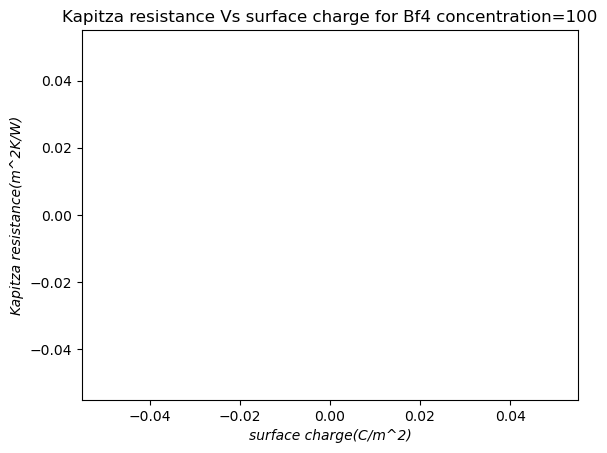

Empty DataFrame
Columns: [0, 1, 2, 3, 4]
Index: []


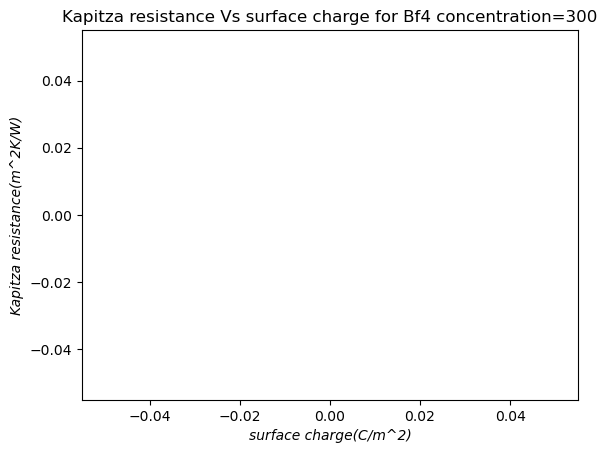

Empty DataFrame
Columns: [0, 1, 2, 3, 4]
Index: []


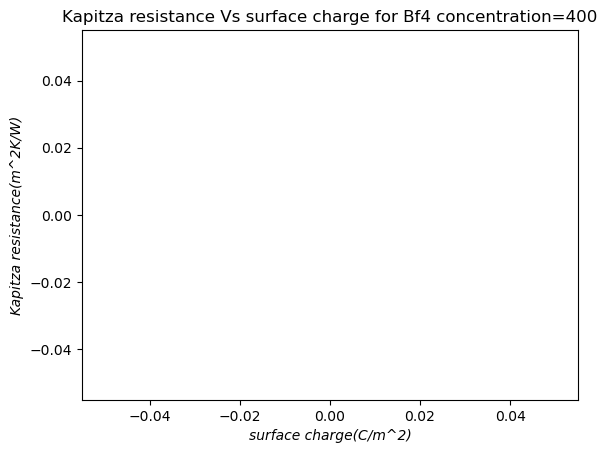

In [11]:
fig, ax = plt.subplots()
conrange= [100,300,400]
for con in conrange:
    data = pd.read_csv("K_vs_charge.dat",sep='\s+',header=None)
    data = pd.DataFrame(data)
    select_con = data.loc[data.iloc[:,0] == con]
    print(select_con)
    x = select_con[1]
    y1 = select_con[2]
    y2 = select_con[3]    
    plt.title('Kapitza resistance Vs surface charge for Bf4 concentration='+str(con))
    plt.plot(x, y1,color="red", marker="o",  linestyle="--",label='kapitza_left')
    plt.plot(x, y2,color="blue", marker="o",  linestyle="--",label='kapitza_right')
    plt.xlabel('surface charge(C/m^2)', style='italic')
    plt.ylabel('Kapitza resistance(m^2K/W)', style='italic')
    plt.show()

## 2. TBR vs Mixture Ratio

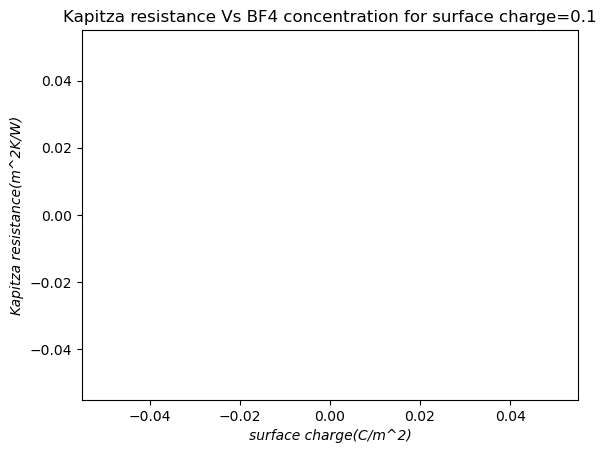

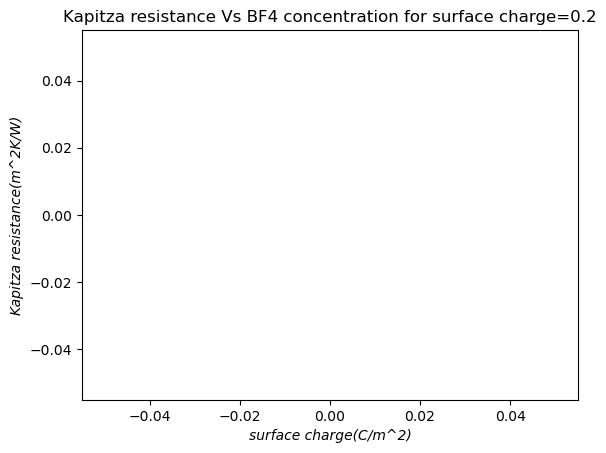

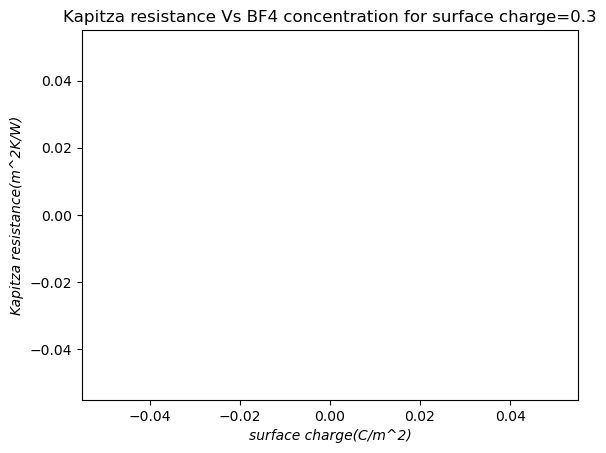

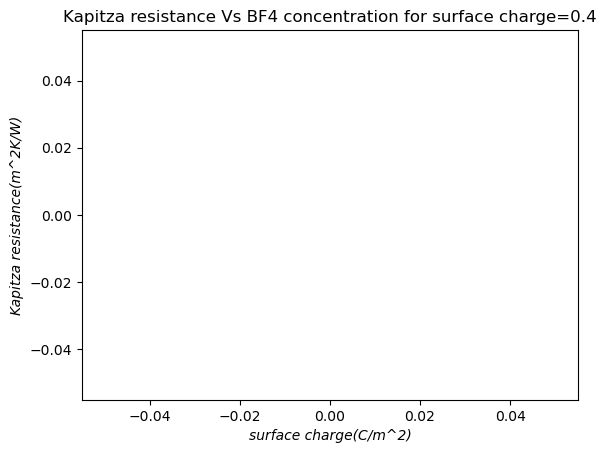

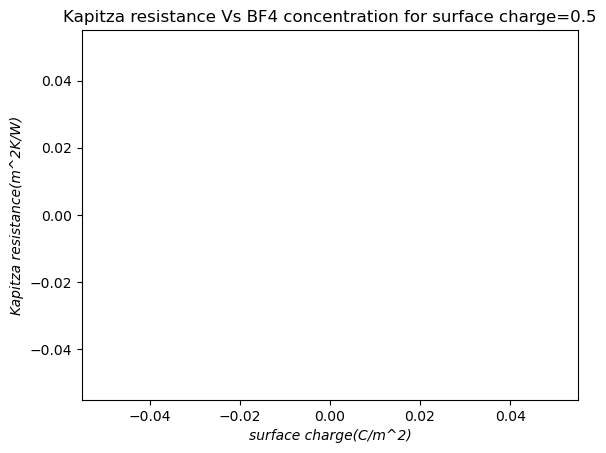

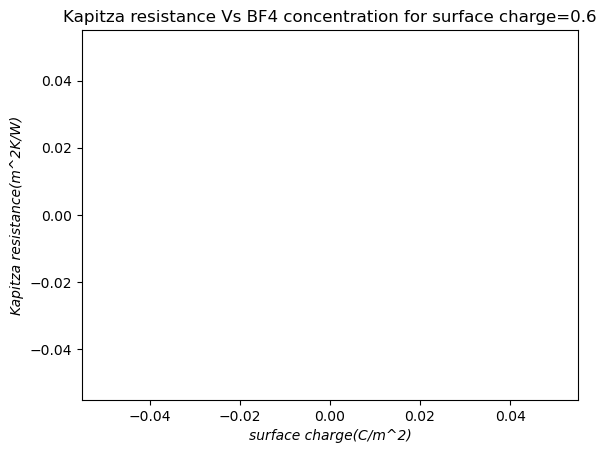

In [9]:
crange=[0.1,0.2,0.3,0.4,0.5,0.6]
for c in crange:
    data = pd.read_csv("K_vs_molarity.dat",sep='\s+',header=None)
    data = pd.DataFrame(data)
    select_con = data.loc[data.iloc[:,0] == c]
    x = select_con[1]
    y1 = select_con[2]
    y2 = select_con[3]    
    plt.title('Kapitza resistance Vs BF4 concentration for surface charge='+str(c))
    plt.plot(x, y1,color="red", marker="o",  linestyle="--",label='kapitza_left')
    plt.plot(x, y2,color="blue", marker="o",  linestyle="--",label='kapitza_right')
    plt.xlabel('surface charge(C/m^2)', style='italic')
    plt.ylabel('Kapitza resistance(m^2K/W)', style='italic')
    plt.show()

## 3. EDL Structure for different Surface Charge

In [10]:
import MDAnalysis
from MDAnalysis.analysis.density import density_from_Universe
from MDAnalysis.analysis.lineardensity import LinearDensity
import numpy as np
from itertools import count

class Smooth_Density(object):
    
    def __init__(self, **kwargs):
        for key,value in kwargs.items():
            setattr(self, key, value)
            
    def density(self, psf, dcd, segid, resname):
        u = MDAnalysis.Universe(psf, dcd)
        mol = u.select_atoms(segid)

        ldens = LinearDensity(mol, grouping ='atoms', binsize=0.5)
        ldens.run()
        D = ldens.results
        x = np.linspace(1,np.size(D['x']['pos']),np.size(D['x']['pos']))
        y = np.linspace(1,np.size(D['y']['pos']),np.size(D['y']['pos']))
        z = np.linspace(1,np.size(D['z']['pos']),np.size(D['z']['pos']))
        return x, D['x']['pos'], y, D['y']['pos'], z, D['z']['pos']

    def density_smooth(self):
        
        folder="T"+str(self.T)+"P"+str(self.P)+"_dT"+str(self.dT)+"_"+str(self.index)
        psf_wat = self.wat_input_files_path+folder+'/inputFiles/waterGnc.psf'
        dcd_wat = self.wat_input_files_path+folder+'/outputFiles/waterGnc.dcd'
        
        x, Dx, y, Dy, z, Dz = self.density(psf_wat, dcd_wat, self.wat_segid, self.wat_resname)
        
#         #Saving the density data
#         fname = self.wat_output_files_path+'water_Density_T'+str(T)+'.dat'
#         np.savetxt(fname, np.column_stack((z, Dz)))
        
        axis = self.axis

        if (axis == "x"):
            wat_X = x/self.conv_factor 
            wat_Den = Dx/self.wat_norm
        elif (axis == "y"):
            wat_X = y/self.conv_factor 
            wat_Den = Dy/self.wat_norm
        else:
            wat_X = z/self.conv_factor 
            wat_Den = Dz/self.wat_norm
        
    def read_denstiy(self, T):
        fname = self.wat_output_files_path+'water_Density_T'+str(T)+'.dat'
        wat_data = np.loadtxt(fname)
        wat_X = wat_data[:,0]/self.conv_factor 
        wat_Den = wat_data[:,1]/np.mean(wat_data[20:60,1])
        
        return wat_X, wat_Den

ImportError: cannot import name 'density_from_Universe' from 'MDAnalysis.analysis.density' (/home/arjun/.local/lib/python3.9/site-packages/MDAnalysis/analysis/density.py)

## 4. EDL Structure for different Mixture Ratio